In [138]:
import osnap
import pickle
import pandas as pd
import numpy as np

In [35]:
# You have to install quilt: pip install quilt
# Also, you have to run: quilt install spatialucr/census

import geopandas as gpd
from quilt.data.spatialucr import census
from shapely.wkb import loads

df = census.tracts_1990()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
df_1990 = gpd.GeoDataFrame(df)

In [ ]:
df = census.tracts_2000()
df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
df_2000 = gpd.GeoDataFrame(df)

In [72]:
#df = census.tracts_2010()
#df['geometry'] = df.wkb.apply(lambda x: loads(x, hex=True))
#df_2010 = gpd.GeoDataFrame(df)

In [57]:
# Filtering Pensylvania through its specific code: https://www.census.gov/geo/maps-data/data/tract_rel_download.html
pa_1990 = df_1990[df_1990.geoid.str[0:2] == '42']
pa_2000 = df_2000[df_2000.geoid.str[0:2] == '42']
#pa_2010 = df_2010[df_2010.GEOID.str[0:2] == '42']

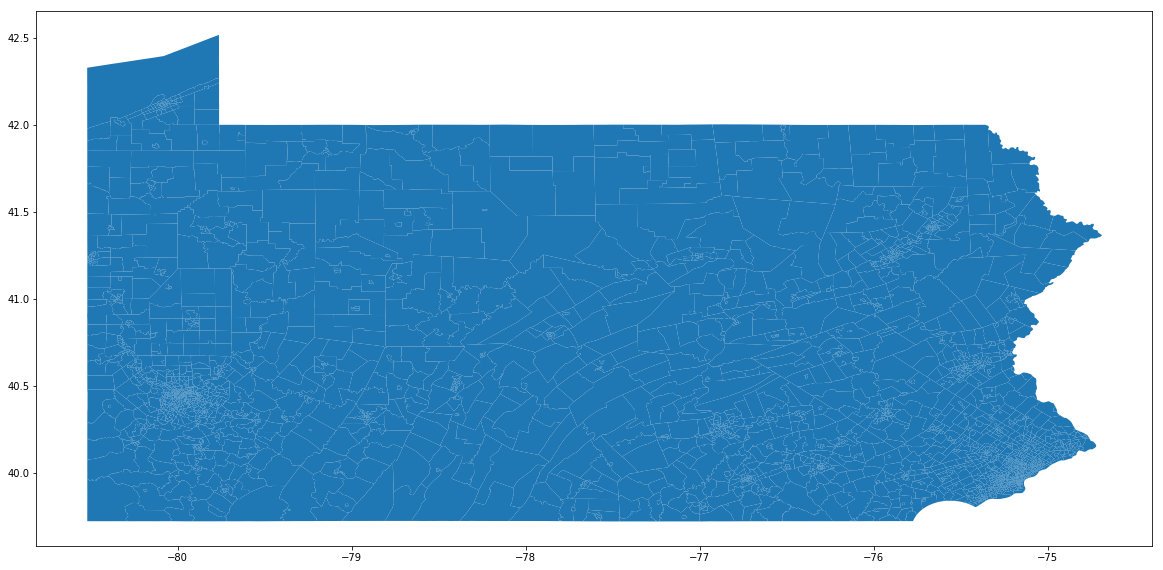

In [85]:
pa_1990.plot(figsize = (20, 20))

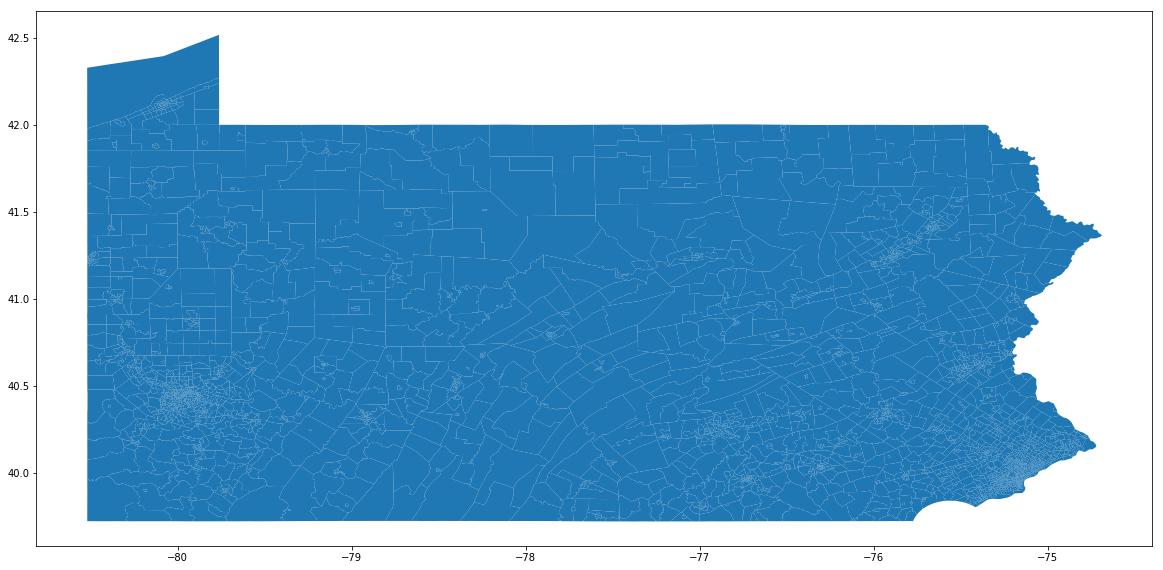

In [86]:
pa_2000.plot(figsize = (20, 20))

In [94]:
#pa_2010.plot(figsize = (20, 20))

In [88]:
# Overlapping both spatial contexts and making and 'new' Pennsylvania
pa_union = gpd.overlay(pa_1990, pa_2000, how='union')

In [89]:
pa_1990.shape

(3167, 4)

In [90]:
pa_2000.shape

(3137, 3)

In [91]:
#pa_2010.shape

(3218, 3)

In [92]:
pa_union.shape

(19824, 6)

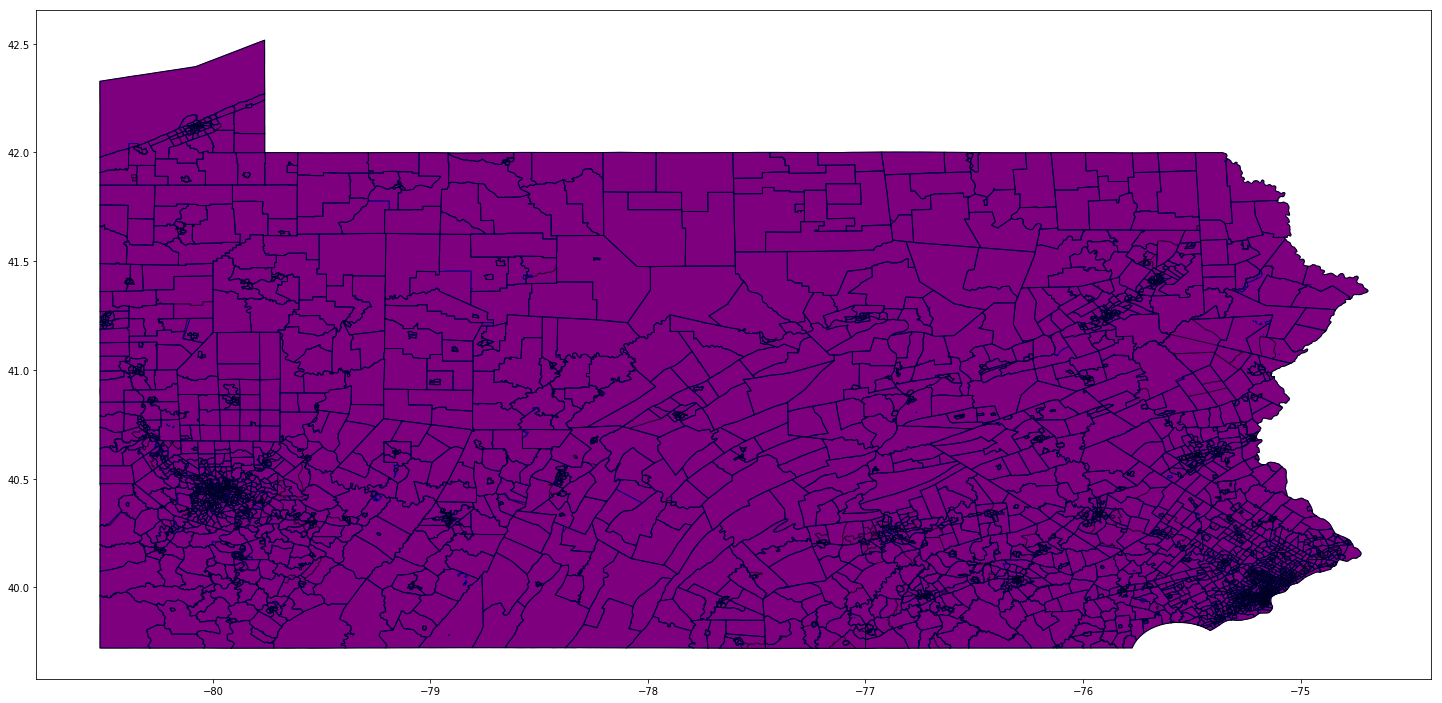

In [93]:
ax = pa_1990.plot(color='red', edgecolor='k', figsize = (25, 25))
pa_2000.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', figsize = (25, 25))

# Reading the Raster Land Cover of Pennsylvania

In [127]:
import rasterio
from rasterio.plot import show
import osmnx as ox
from rasterio.mask import mask
from fiona.crs import from_epsg
import pycrs

filepath = 'C:/Users/renan/Desktop/harmonization_osnap/NLCD2011_LC_Pennsylvania/NLCD2011_LC_Pennsylvania.tif'
dem = rasterio.open(filepath)

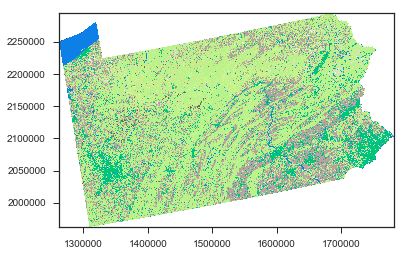

In [432]:
show(dem, cmap='terrain')

In [111]:
# Retrieve ‘Centre’ county from OpenStreetMap

centre_q = "Centre, Pennsylvania, United States"
centre_pre = ox.gdf_from_place(centre_q)

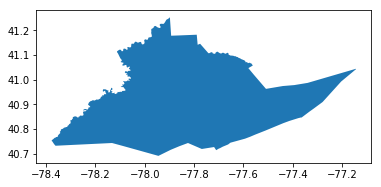

In [113]:
centre_pre.plot()

Reproject the regions to same CRS as the raster

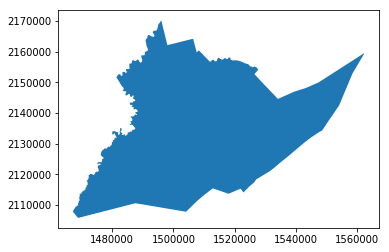

In [140]:
centre = centre_pre.to_crs(crs = dem.crs.data)
centre.plot()

## Clipping it

In [128]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [129]:
geo = centre
coords = getFeatures(geo)
out_img, out_transform = mask(dataset = dem, shapes = coords, crop = True)
out_meta = dem.meta.copy()

This is an Albers Equal Area with NAD83. The corresponding code, I found here: http://spatialreference.org/ref/?search=albers+equal

In [132]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parser.from_epsg_code(3083).to_proj4()}
                 )

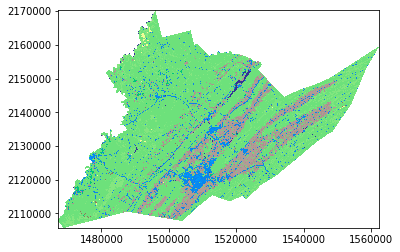

In [146]:
out_tif = r"C:\Users\renan\Desktop\harmonization_osnap\Centre_Clipped2.tif"

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
    
clipped = rasterio.open(out_tif)
show((clipped), cmap='terrain')

## Convert the clipped raster to numpy array

In [136]:
red = clipped.read()
type(red)

numpy.ndarray

In [139]:
# Inspired in https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
x = np.ndarray.flatten(red) # # You to flatten the numpy array to count the frequency of numbers
y = np.bincount(x)
ii = np.nonzero(y)[0]

# Table of pixel types of this county
list(zip(ii,y[ii]))

[(11, 16690),
 (21, 175821),
 (22, 60455),
 (23, 16843),
 (24, 5127),
 (31, 14912),
 (41, 2001401),
 (42, 224827),
 (43, 189464),
 (52, 5694),
 (71, 3899),
 (81, 215054),
 (82, 275606),
 (90, 307),
 (95, 168),
 (255, 3597466)]

Each pixel represent one class in the Land.

We need to build a correspondence of the pixels code and what they represent: https://www.mrlc.gov/sites/default/files/metadata/landcover.html

Explorer: https://www.mrlc.gov/viewer/

In [105]:
land_cover_corresp = {'Code': [11, 
                               12,
                               21,
                               22,
                               23,
                               24,
                               31,
                               41,
                               42,
                               43,
                               51,
                               52,
                               71,
                               72,
                               73,
                               74,
                               81,
                               82,
                               90,
                               95,
                              
                               255],
                      
                      'Long_Description': ['Open Water - All areas of open water, generally with less than 25% cover or vegetation or soil',
                                           'Perennial Ice/Snow - All areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.',
                                           'Developed, Open Space - Includes areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20 percent of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.',
                                           'Developed, Low Intensity -Includes areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20-49 percent of total cover. These areas most commonly include single-family housing units.',
                                           'Developed, Medium Intensity - Includes areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50-79 percent of the total cover. These areas most commonly include single-family housing units.',
                                           'Developed, High Intensity - Includes highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80 to 100 percent of the total cover.',
                                           'Barren Land (Rock/Sand/Clay) - Barren areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.',
                                           'Deciduous Forest - Areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75 percent of the tree species shed foliage simultaneously in response to seasonal change.',
                                           'Evergreen Forest - Areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75 percent of the tree species maintain their leaves all year. Canopy is never without green foliage.',
                                           'Mixed Forest - Areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75 percent of total tree cover.',
                                           'Dwarf Scrub - Alaska only areas dominated by shrubs less than 20 centimeters tall with shrub canopy typically greater than 20% of total vegetation. This type is often co-associated with grasses, sedges, herbs, and non-vascular vegetation.',
                                           'Shrub/Scrub - Areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions.',
                                           'Grassland/Herbaceous - Areas dominated by grammanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.',
                                           'Sedge/Herbaceous - Alaska only areas dominated by sedges and forbs, generally greater than 80% of total vegetation. This type can occur with significant other grasses or other grass like plants, and includes sedge tundra, and sedge tussock tundra.',
                                           'Lichens - Alaska only areas dominated by fruticose or foliose lichens generally greater than 80% of total vegetation.',
                                           'Moss - Alaska only areas dominated by mosses, generally greater than 80% of total vegetation.',
                                           'Pasture/Hay - Areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20 percent of total vegetation.',
                                           'Cultivated Crops - Areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20 percent of total vegetation. This class also includes all land being actively tilled.',
                                           'Woody Wetlands - Areas where forest or shrub land vegetation accounts for greater than 20 percent of vegetative cover and the soil or substrate is periodically saturated with or covered with water.',
                                           'Emergent Herbaceous Wetlands - Areas where perennial herbaceous vegetation accounts for greater than 80 percent of vegetative cover and the soil or substrate is periodically saturated with or covered with water.',
                                          
                                           'NA'],
                      
                      'Short_Description': ['Open Water', 
                                            'Perennial Ice/Snow',
                                            'Developed, Open Space',
                                            'Developed, Low Intensity',
                                            'Developed, Medium Intensity',
                                            'Developed, High Intensity',
                                            'Barren Land (Rock/Sand/Clay)',
                                            'Deciduous Forest',
                                            'Evergreen Forest',
                                            'Mixed Forest',
                                            'Dwarf Scrub',
                                            'Shrub/Scrub',
                                            'Grassland/Herbaceous',
                                            'Sedge/Herbaceous',
                                            'Lichens',
                                            'Moss',
                                            'Pasture/Hay',
                                            'Cultivated Crops',
                                            'Woody Wetlands',
                                            'Emergent Herbaceous Wetlands',
                                            
                                            'NA'
                                           ]
                     }

land_cover_corresp = pd.DataFrame.from_dict(land_cover_corresp)

In [106]:
land_cover_corresp

,Code,Long_Description,Short_Description
0,11,"Open Water - All areas of open water, generall...",Open Water
1,12,Perennial Ice/Snow - All areas characterized b...,Perennial Ice/Snow
2,21,"Developed, Open Space - Includes areas with a ...","Developed, Open Space"
3,22,"Developed, Low Intensity -Includes areas with ...","Developed, Low Intensity"
4,23,"Developed, Medium Intensity - Includes areas w...","Developed, Medium Intensity"
5,24,"Developed, High Intensity - Includes highly de...","Developed, High Intensity"
6,31,Barren Land (Rock/Sand/Clay) - Barren areas of...,Barren Land (Rock/Sand/Clay)
7,41,Deciduous Forest - Areas dominated by trees ge...,Deciduous Forest
8,42,Evergreen Forest - Areas dominated by trees ge...,Evergreen Forest
9,43,Mixed Forest - Areas dominated by trees genera...,Mixed Forest


# Reibel (2007) approach: using 2000 to interpolate 1990

Firstly, we need to check the amount of area in each unit.

In [178]:
def return_area_profile_old(polygon, raster, polygon_crs = {'init': 'epsg:4326'}): # , epsg_code = 3083
    
    # polygon: polygon for the profile
    # raster: the associated raster (from rasterio.open)
    # epsg_code: code of the EPSG to update raster
    # polygon_crs: the crs code given by a dict of the polygon
    
    polygon.crs = polygon_crs

    polygon_projected = polygon.to_crs(crs = raster.crs.data)
    
    coords = getFeatures(polygon_projected)
    out_img = mask(dataset = dem, shapes = coords, crop = True)[0]
    
    # It is not needed to save the clipped raster 
    #out_meta = raster.meta.copy()
    
    #out_meta.update({"driver": "GTiff",
    #                 "height": out_img.shape[1],
    #                 "width": out_img.shape[2],
    #                 "transform": out_transform,
    #                 "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()})
    
    x = np.ndarray.flatten(out_img)
    y = np.bincount(x)
    ii = np.nonzero(y)[0]

    # Table of pixel types of this county
    profile = list(zip(ii,y[ii]))

    return profile

In [247]:
def return_area_profile(polygon, raster, polygon_crs = {'init': 'epsg:4326'}):
    
    # polygon: polygon for the profile (it can be a row of a geopandas)
    # raster: the associated raster (from rasterio.open)
    # polygon_crs: the crs code given by a dict of the polygon
    
    polygon.crs = polygon_crs
    polygon_projected = polygon.to_crs(crs = raster.crs.data)
    
    coords = getFeatures(polygon_projected)
    out_img = mask(dataset = dem, shapes = coords, crop = True)[0]
    
    x = np.ndarray.flatten(out_img)
    y = np.bincount(x)
    ii = np.nonzero(y)[0]

    # Table of pixel types of the polygon
    #profile = list(zip(ii,y[ii])) # list like
    profile = pd.DataFrame.from_dict(dict(zip(np.core.defchararray.add('Type_', ii.astype(str)),y[ii].reshape(len(y[ii]),1)))) # pandas like
    
    polygon_with_profile = pd.concat([polygon.reset_index(drop=True), profile], axis = 1) # Appends in the end

    return polygon_with_profile

In [250]:
pa_2000[pa_2000.geoid == '42001030101']

,geoid,wkb,geometry
0,42001030101,0103000000010000003A010000BF61A2410A4653C0C07A...,"POLYGON ((-77.094376 39.994956, -77.094802 39...."


In [251]:
test_profile = return_area_profile(pa_2000[pa_2000.geoid == '42001030101'], dem)
test_profile

,geoid,wkb,geometry,Type_11,Type_21,Type_22,Type_23,Type_24,Type_31,Type_41,Type_42,Type_43,Type_52,Type_71,Type_81,Type_82,Type_90,Type_95,Type_255
0,42001030101,0103000000010000003A010000BF61A2410A4653C0C07A...,"POLYGON ((-77.094376 39.994956, -77.094802 39....",504,5900,1456,369,74,13,11548,432,365,4587,317,14303,19041,2696,137,78118


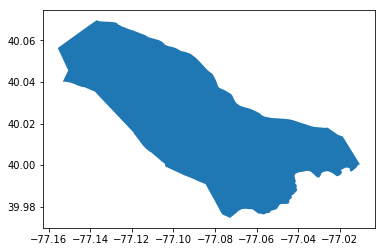

In [237]:
test_profile.plot()

In [285]:
def append_profile_in_gdf(geodataframe, raster):
    
    final_data = gpd.GeoDataFrame()
    
    for i in range(len(geodataframe)):
        
        aux = return_area_profile(geodataframe.iloc[[i]], raster = raster)
        final_data = pd.concat([final_data.reset_index(drop = True), aux], axis = 0)
    
    return final_data

In [286]:
profiled_pa_2000 = append_profile_in_gdf(pa_2000, raster = dem)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


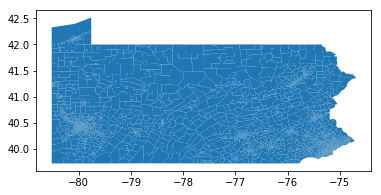

In [288]:
profiled_pa_2000.plot()

In [295]:
profiled_pa_2000['Total_Pixels'] = profiled_pa_2000.loc[:, profiled_pa_2000.columns.str.startswith('Type_')].sum(axis = 1)
profiled_pa_2000.head()

,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,Type_31,Type_41,Type_42,...,Type_52,Type_71,Type_81,Type_82,Type_90,Type_95,geoid,geometry,wkb,Total_Pixels
0,NaN,504.0,5900.0,1456.0,369.0,74.0,78118,13.0,11548.0,432.0,...,4587.0,317.0,14303.0,19041.0,2696.0,137.0,42001030101,"POLYGON ((-77.094376 39.994956, -77.094802 39....",0103000000010000003A010000BF61A2410A4653C0C07A...,139860.0
1,NaN,870.0,6655.0,2422.0,429.0,70.0,87720,74.0,11223.0,556.0,...,4752.0,397.0,19667.0,27071.0,2249.0,226.0,42001030102,"POLYGON ((-77.097065 39.947374, -77.099249 39....",010300000001000000E701000085251E50364653C0558A...,164808.0
2,NaN,180.0,9717.0,3195.0,929.0,147.0,157421,34.0,24404.0,680.0,...,9408.0,568.0,35855.0,42651.0,5555.0,423.0,42001030200,"POLYGON ((-77.126577 39.908316, -77.127557 39....",0103000000010000005701000040DB6AD6194853C07E37...,292110.0
3,NaN,452.0,10015.0,1593.0,477.0,191.0,98528,NaN,56542.0,6413.0,...,2036.0,252.0,29966.0,9006.0,1344.0,104.0,42001030300,"POLYGON ((-77.351641 39.944281, -77.35173 39.9...",010300000001000000BA000000B2BB4049815653C0F99D...,222939.0
4,NaN,999.0,11942.0,3244.0,387.0,38.0,125888,183.0,97451.0,13469.0,...,1016.0,676.0,20985.0,33727.0,3917.0,722.0,42001030400,"POLYGON ((-77.463875 39.860685, -77.464944 39....",01030000000100000061010000A69BC420B05D53C03194...,325822.0


## Fitting a Regression for the population over the area types

First, let's add the populaiton in each tract using osnap.

In [297]:
import os
os.chdir('C:\\Users\\renan\\Desktop\\osnap_data')
from osnap.data import read_ltdb

sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

df_pre = read_ltdb(sample = sample, fullcount = full)

In [303]:
df = df_pre[['n_total_pop', 'year']]

df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
df.head()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,n_total_pop,year,geoid,state
geoid,,,,
01001020500,9.0,1970,01001020500,01
01003010100,3470.0,1970,01003010100,01
01003010200,1881.0,1970,01003010200,01
01003010300,3724.0,1970,01003010300,01
01003010400,2600.0,1970,01003010400,01


In [317]:
#df_pa_1990 = df[(df['state'] == '42') & (df['year'] == 1990)][['geoid', 'n_total_pop']]
df_pa_2000 = df[(df['state'] == '42') & (df['year'] == 2000)][['geoid', 'n_total_pop']]

In [314]:
df_pa_2000.head()

,geoid,n_total_pop
geoid,,
42001030101,42001030101,2489.0
42001030102,42001030102,5106.0
42001030200,42001030200,5122.0
42001030300,42001030300,3547.0
42001030400,42001030400,5433.0


In [320]:
full_pa_2000 = profiled_pa_2000.merge(df_pa_2000, on = 'geoid')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'geoid' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


In [321]:
full_pa_2000.head()

,Type_0,Type_11,Type_21,Type_22,Type_23,Type_24,Type_255,Type_31,Type_41,Type_42,...,Type_71,Type_81,Type_82,Type_90,Type_95,geoid,geometry,wkb,Total_Pixels,n_total_pop
0,NaN,504.0,5900.0,1456.0,369.0,74.0,78118,13.0,11548.0,432.0,...,317.0,14303.0,19041.0,2696.0,137.0,42001030101,"POLYGON ((-77.094376 39.994956, -77.094802 39....",0103000000010000003A010000BF61A2410A4653C0C07A...,139860.0,2489.0
1,NaN,870.0,6655.0,2422.0,429.0,70.0,87720,74.0,11223.0,556.0,...,397.0,19667.0,27071.0,2249.0,226.0,42001030102,"POLYGON ((-77.097065 39.947374, -77.099249 39....",010300000001000000E701000085251E50364653C0558A...,164808.0,5106.0
2,NaN,180.0,9717.0,3195.0,929.0,147.0,157421,34.0,24404.0,680.0,...,568.0,35855.0,42651.0,5555.0,423.0,42001030200,"POLYGON ((-77.126577 39.908316, -77.127557 39....",0103000000010000005701000040DB6AD6194853C07E37...,292110.0,5122.0
3,NaN,452.0,10015.0,1593.0,477.0,191.0,98528,NaN,56542.0,6413.0,...,252.0,29966.0,9006.0,1344.0,104.0,42001030300,"POLYGON ((-77.351641 39.944281, -77.35173 39.9...",010300000001000000BA000000B2BB4049815653C0F99D...,222939.0,3547.0
4,NaN,999.0,11942.0,3244.0,387.0,38.0,125888,183.0,97451.0,13469.0,...,676.0,20985.0,33727.0,3917.0,722.0,42001030400,"POLYGON ((-77.463875 39.860685, -77.464944 39....",01030000000100000061010000A69BC420B05D53C03194...,325822.0,5433.0


C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


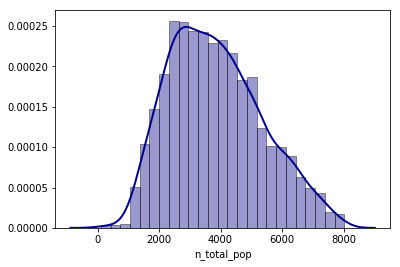

In [322]:
# Plotting the population
sns.distplot(full_pa_2000.n_total_pop, 
                 color = 'darkblue', 
                 hist_kws = {'edgecolor':'black'},
                 kde_kws = {'linewidth': 2})

In [323]:
full_pa_2000.n_total_pop.mean()

3849.2644028996565

In [324]:
full_pa_2000.n_total_pop.var()

2246787.7976216795

In [325]:
# Overdispersion (quasi-poisson)
# !pip install git+https://github.com/madrury/py-glm.git

  Cloning https://github.com/madrury/py-glm.git to c:\users\renan\appdata\local\temp\pip-req-build-bpsg3nke
  Running setup.py bdist_wheel for py-glm: started
  Running setup.py bdist_wheel for py-glm: finished with status 'done'
  Stored in directory: C:\Users\renan\AppData\Local\Temp\pip-ephem-wheel-cache-ydhgx__e\wheels\ba\f8\77\41a1cc9756ab50434bbadffdf60a20742fc01bfd5ea3e056eb
Successfully built py-glm


You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [328]:
#from glm.families import QuasiPoisson
#from glm.glm import GLM
#model = GLM(family = QuasiPoisson())
#model.fit(full_pa_2000, formula='n_total_pop ~ Type_11')

In [353]:
from sklearn import datasets, linear_model

df_reg = full_pa_2000[['Type_21', 'Type_22', 'n_total_pop']].dropna()
X = df_reg[['Type_21', 'Type_22']]
y = df_reg[['n_total_pop']]

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept = False)

# Train the model using the training sets
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [354]:
regr.coef_

array([[0.03151069, 1.90946391]])

In [409]:
full_pa_2000.columns.str.startswith('Type_')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

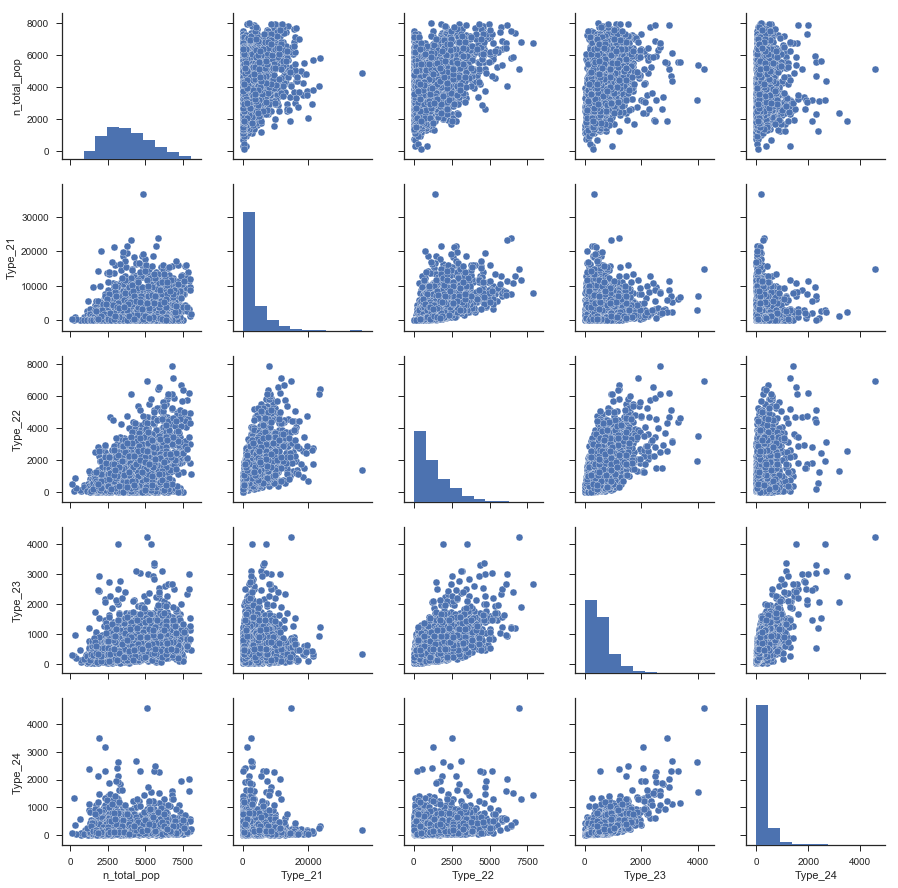

In [419]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
iris = full_pa_2000[['n_total_pop', 'Type_21', 'Type_22', 'Type_23', 'Type_24']].dropna()
g = sns.pairplot(iris)

In [ ]:
corr = d.corr()

# Fitting regressions with statsmodels

In [420]:
import statsmodels.formula.api as smf

results = smf.ols('n_total_pop ~ -1 + Type_21 + Type_22 + Type_23 + Type_24', data = full_pa_2000).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            n_total_pop   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1902.
Date:                Mon, 28 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:24:29   Log-Likelihood:                -23149.
No. Observations:                2556   AIC:                         4.631e+04
Df Residuals:                    2552   BIC:                         4.633e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Type_21        0.1618      0.015     10.555      0.0

In [389]:
full_pa_2000['Rel_Type_21'] = full_pa_2000['Type_21'] / full_pa_2000['Total_Pixels']
full_pa_2000['Rel_Type_22'] = full_pa_2000['Type_22'] / full_pa_2000['Total_Pixels']
full_pa_2000['Rel_Type_23'] = full_pa_2000['Type_23'] / full_pa_2000['Total_Pixels']
full_pa_2000['Rel_Type_24'] = full_pa_2000['Type_24'] / full_pa_2000['Total_Pixels']

results = smf.ols('n_total_pop ~ -1 + Rel_Type_21 + Rel_Type_22 + Rel_Type_23 + Rel_Type_24', data = full_pa_2000).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            n_total_pop   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1256.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:40:20   Log-Likelihood:                -23524.
No. Observations:                2556   AIC:                         4.706e+04
Df Residuals:                    2552   BIC:                         4.708e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Rel_Type_21  2.443e+04    810.244     30.147      

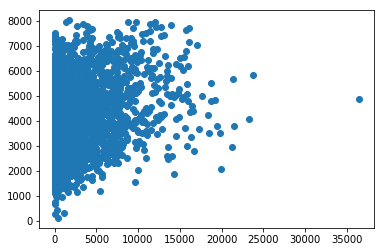

In [371]:
import matplotlib
%matplotlib inline
matplotlib.pyplot.scatter(full_pa_2000.Type_21, full_pa_2000.n_total_pop)

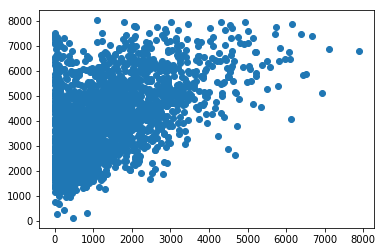

In [372]:
matplotlib.pyplot.scatter(full_pa_2000.Type_22, full_pa_2000.n_total_pop)

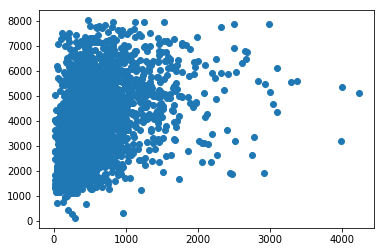

In [373]:
matplotlib.pyplot.scatter(full_pa_2000.Type_23, full_pa_2000.n_total_pop)

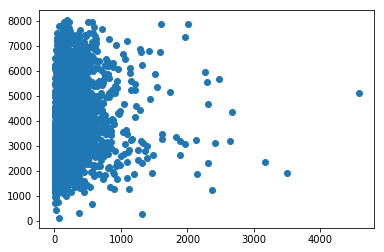

In [374]:
matplotlib.pyplot.scatter(full_pa_2000.Type_24, full_pa_2000.n_total_pop)

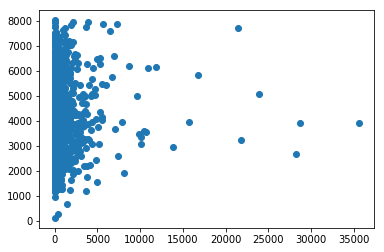

In [376]:
matplotlib.pyplot.scatter(full_pa_2000.Type_11, full_pa_2000.n_total_pop)

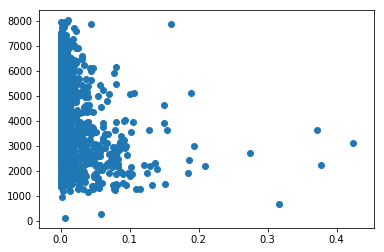

In [390]:
# Relative Values
matplotlib.pyplot.scatter(full_pa_2000.Type_11/full_pa_2000.Total_Pixels, full_pa_2000.n_total_pop)

# Relative regression using only on the selected types

In [391]:
import statsmodels.formula.api as smf

full_pa_2000['Sub_Total'] = full_pa_2000['Type_21'] + full_pa_2000['Type_22'] + full_pa_2000['Type_23'] + full_pa_2000['Type_24']

full_pa_2000['Sub_Rel_Type_21'] = full_pa_2000['Type_21'] / full_pa_2000['Sub_Total']
full_pa_2000['Sub_Rel_Type_22'] = full_pa_2000['Type_22'] / full_pa_2000['Sub_Total']
full_pa_2000['Sub_Rel_Type_23'] = full_pa_2000['Type_23'] / full_pa_2000['Sub_Total']
full_pa_2000['Sub_Rel_Type_24'] = full_pa_2000['Type_24'] / full_pa_2000['Sub_Total']

results = smf.ols('n_total_pop ~ -1 + Sub_Rel_Type_21 + Sub_Rel_Type_22 + Sub_Rel_Type_23 + Sub_Rel_Type_24', data = full_pa_2000).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            n_total_pop   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     38.80
Date:                Mon, 28 Jan 2019   Prob (F-statistic):           1.64e-24
Time:                        11:29:58   Log-Likelihood:                -22261.
No. Observations:                2556   AIC:                         4.453e+04
Df Residuals:                    2552   BIC:                         4.455e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sub_Rel_Type_21  4290.6534     91.989     

# Using the original regression betas to interpolate the other year

In [423]:
import statsmodels.formula.api as smf

results = smf.ols('n_total_pop ~ -1 + Type_21 + Type_22 + Type_23 + Type_24', data = full_pa_2000).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            n_total_pop   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1902.
Date:                Mon, 28 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:25:30   Log-Likelihood:                -23149.
No. Observations:                2556   AIC:                         4.631e+04
Df Residuals:                    2552   BIC:                         4.633e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Type_21        0.1618      0.015     10.555      0.0

In [425]:
dem_numpy = dem.read()
type(dem_numpy)

numpy.ndarray

In [428]:
dem_numpy

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

Now, what you have to do is basically estimate the amount of population using another shapefile. You clip the other shapefile and then built this estimated population by plugging the amount of land type in each of these types and multiplying by the estimated betas.

Or you can estimate the (rescaled) amount of population in each grid cell just as in Reibel (2007). 

In [440]:
def insert_raw_estimates(numpy):
    numpy = np.where(((dem_numpy == 21) | (dem_numpy == 22) | (dem_numpy == 23) | (dem_numpy == 24)), numpy, 0) 
    numpy = np.where(numpy == 21, 0.1618, numpy)
    numpy = np.where(numpy == 22, 0.5372, numpy) 
    numpy = np.where(numpy == 23, 3.6943, numpy) 
    numpy = np.where(numpy == 24, -1.5948, numpy) 
    return numpy

In [480]:
test = insert_raw_estimates(dem_numpy)
test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [509]:
dem_numpy.shape

(1, 11064, 17330)

In [481]:
test.max()

3.6943

In [472]:
from PIL import Image
im = Image.fromarray(clipped)

AttributeError: 'DatasetReader' object has no attribute '__array_interface__'

In [483]:
from PIL import Image
im = Image.fromarray(test)

TypeError: Cannot handle this data type

In [487]:
im = Image.fromarray(np.uint8(test))

TypeError: Cannot handle this data type

In [486]:
test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

TypeError: Invalid dimensions for image data

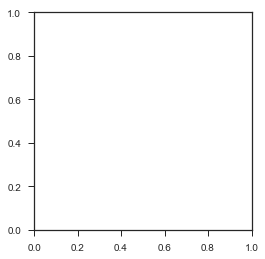

In [490]:
import matplotlib.pyplot as plt
plt.imshow(test)

In [497]:
type(clipped)

rasterio.io.DatasetReader

In [499]:
type(clipped)

rasterio.io.DatasetReader

In [502]:
clipped.read()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [503]:
test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [504]:
test.shape

(1, 11064, 17330)

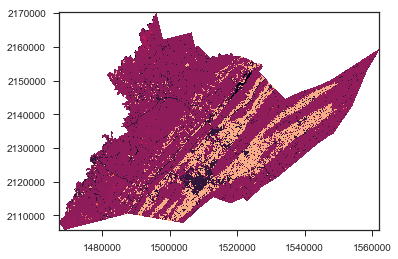

In [505]:
show(clipped)

In [506]:
im2 = clipped.read()

In [507]:
im2.shape

(1, 2149, 3166)